# Import Libraries

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Set up seaborn
sns.set()

# Data Loading

In [2]:
# Load master data
items_df = pd.read_csv('datasets/items.csv', sep='|')

# Load transaction data
orders_df = pd.read_csv('datasets/orders.csv', sep='|')

# Load info data
infos_df = pd.read_csv('datasets/infos.csv', sep='|')

# Explore the loaded data
print("Items data:")
display(items_df.head())

print("\nOrders data:")
display(orders_df.head())

print("\nInfos data:")
display(infos_df.head())

Items data:


,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04



Orders data:


,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19



Infos data:


,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


In [3]:
# Data Info
print("Items data:")
display(items_df.info(show_counts=True))

print("\nOrders data:")
display(orders_df.info(show_counts=True))

print("\nInfos data:")
display(infos_df.info(show_counts=True))

Items data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   itemID                  10463 non-null  int64  
 1   brand                   10463 non-null  int64  
 2   manufacturer            10463 non-null  int64  
 3   customerRating          10463 non-null  float64
 4   category1               10463 non-null  int64  
 5   category2               10463 non-null  int64  
 6   category3               10463 non-null  int64  
 7   recommendedRetailPrice  10463 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 654.1 KB


None


Orders data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   time        2181955 non-null  object 
 1   transactID  2181955 non-null  int64  
 2   itemID      2181955 non-null  int64  
 3   order       2181955 non-null  int64  
 4   salesPrice  2181955 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 83.2+ MB


None


Infos data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemID           10463 non-null  int64  
 1   simulationPrice  10463 non-null  float64
 2   promotion        1843 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 245.4+ KB


None

# Data Preprocessing

In [4]:
# Drop unnecessary columns
infos_df.drop("promotion", axis=1, inplace=True)
orders_df.drop("transactID", axis=1, inplace=True)

In [5]:
# Merge dataframes
merged_df = pd.merge(orders_df, items_df, on="itemID", how="left")
merged_df = pd.merge(merged_df, infos_df, on="itemID", how="left")

In [6]:
# Convert the "time" column to datetime format
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Extract year, month, and day into separate columns
merged_df['year'] = merged_df['time'].dt.year
merged_df['month'] = merged_df['time'].dt.month
merged_df['day'] = merged_df['time'].dt.day

# Drop the original "time" column
merged_df.drop('time', axis=1, inplace=True)

merged_df.head()

,itemID,order,salesPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,year,month,day
0,450,1,17.42,0,7,0.00,1,2,1,27.00,17.42,2018,1,1
1,83,1,5.19,0,4,0.00,1,1,1,12.89,5.19,2018,1,1
2,7851,2,20.47,0,202,4.75,4,39,7,11.75,20.47,2018,1,1
3,450,1,17.42,0,7,0.00,1,2,1,27.00,17.42,2018,1,1
4,83,1,5.19,0,4,0.00,1,1,1,12.89,5.19,2018,1,1


In [7]:
# Data Aggregation

In [8]:
# Group the data and perform aggregation
grouped_df = (
    merged_df.groupby(["itemID", "year", "month", "day"])
    .agg(
        {
            "order": "sum",
            "brand": "max",
            "manufacturer": "max",
            "customerRating": "max",
            "category1": "max",
            "category2": "max",
            "category3": "max",
            "salesPrice": "max",
            "recommendedRetailPrice": "max",
            "simulationPrice": "max",
        }
    )
    .reset_index()
)

grouped_df.head()

,itemID,year,month,day,order,brand,manufacturer,customerRating,category1,category2,category3,salesPrice,recommendedRetailPrice,simulationPrice
0,1,2018,1,23,1,0,1,4.38,1,1,1,3.11,8.84,3.43
1,1,2018,1,25,1,0,1,4.38,1,1,1,3.11,8.84,3.43
2,1,2018,1,29,307,0,1,4.38,1,1,1,3.11,8.84,3.43
3,1,2018,1,30,3,0,1,4.38,1,1,1,3.11,8.84,3.43
4,1,2018,1,31,1,0,1,4.38,1,1,1,3.11,8.84,3.43


# Feature Engineering

In [9]:
def weekend_or_weekday(year, month, day):
    d = datetime(int(year), int(month), int(day))
    if d.weekday() > 4:
        return 1
    else:
        return 0


def sales(orders, sales_price):
    return orders * sales_price


# Create the is_weekend column
grouped_df["is_weekend"] = grouped_df.apply(
    lambda row: weekend_or_weekday(row["year"], row["month"], row["day"]), axis=1
)

# Create the day_of_week column
grouped_df["day_of_week"] = grouped_df.apply(
    lambda row: datetime(
        int(row["year"]), int(row["month"]), int(row["day"])
    ).weekday(),
    axis=1,
)

# Create the sales column
grouped_df["sales"] = grouped_df.apply(
    lambda row: sales(row["order"], row["salesPrice"]),
    axis=1,
)

grouped_df.head()

,itemID,year,month,day,order,brand,manufacturer,customerRating,category1,category2,category3,salesPrice,recommendedRetailPrice,simulationPrice,is_weekend,day_of_week,sales
0,1,2018,1,23,1,0,1,4.38,1,1,1,3.11,8.84,3.43,0,1,3.11
1,1,2018,1,25,1,0,1,4.38,1,1,1,3.11,8.84,3.43,0,3,3.11
2,1,2018,1,29,307,0,1,4.38,1,1,1,3.11,8.84,3.43,0,0,954.77
3,1,2018,1,30,3,0,1,4.38,1,1,1,3.11,8.84,3.43,0,1,9.33
4,1,2018,1,31,1,0,1,4.38,1,1,1,3.11,8.84,3.43,0,2,3.11


# Exploratory Data Analysis (EDA)

In [10]:
print(f"Number of unique items: {grouped_df['itemID'].nunique()}")

Number of unique items: 9840


## Top Ten Most Ordered Items

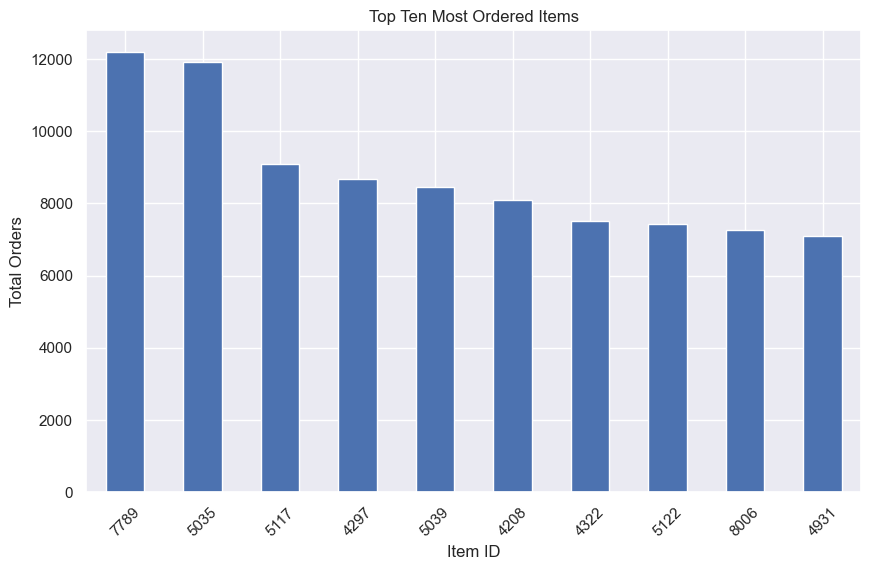

In [11]:
# Get the top ten most ordered items
top_ten_items = grouped_df.groupby('itemID')['order'].sum().nlargest(10)

# Plot the top ten most ordered items
plt.figure(figsize=(10, 6))
top_ten_items.plot(kind='bar')
plt.xlabel('Item ID')
plt.ylabel('Total Orders')
plt.title('Top Ten Most Ordered Items')
plt.xticks(rotation=45)
plt.show()

## Month-wise Total Orders

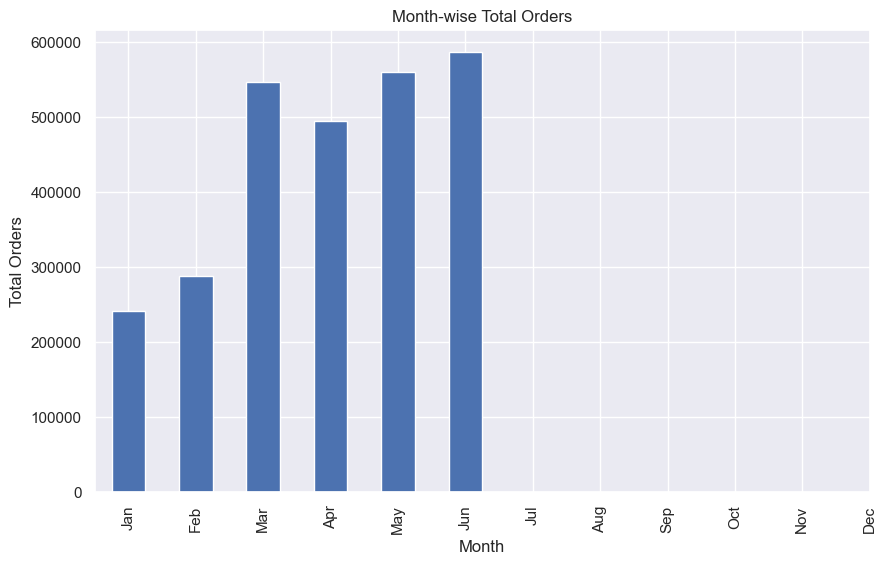

In [12]:
# Group the data by month and calculate the total orders
monthly_orders = grouped_df.groupby('month')['order'].sum()

# Plot the month-wise total orders
plt.figure(figsize=(10, 6))
monthly_orders.plot(kind="bar")
plt.title('Month-wise Total Orders')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Month-wise Total Sales

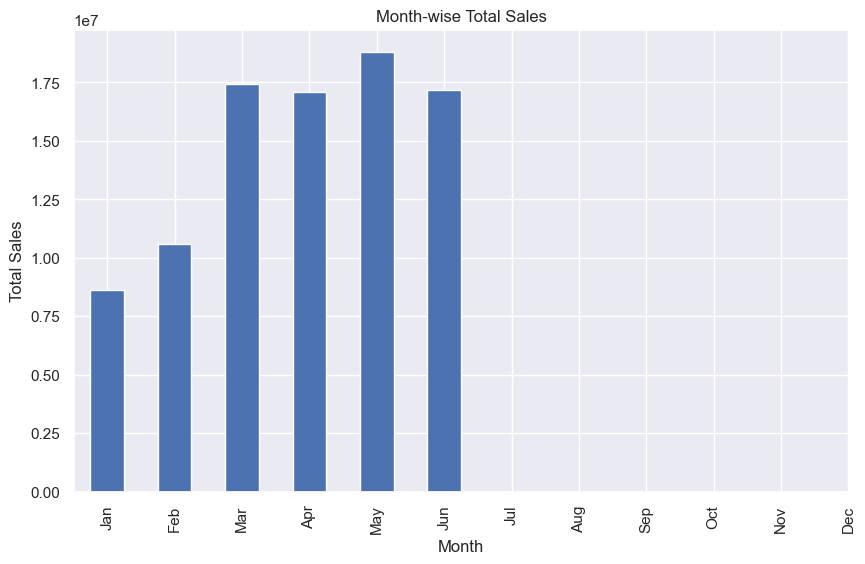

In [14]:
# Group the data by month and calculate the total sales
monthly_sales = grouped_df.groupby('month')['sales'].sum()

# Plot the month-wise total sales
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind="bar")
plt.title('Month-wise Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Variation of Orders as Month Closes

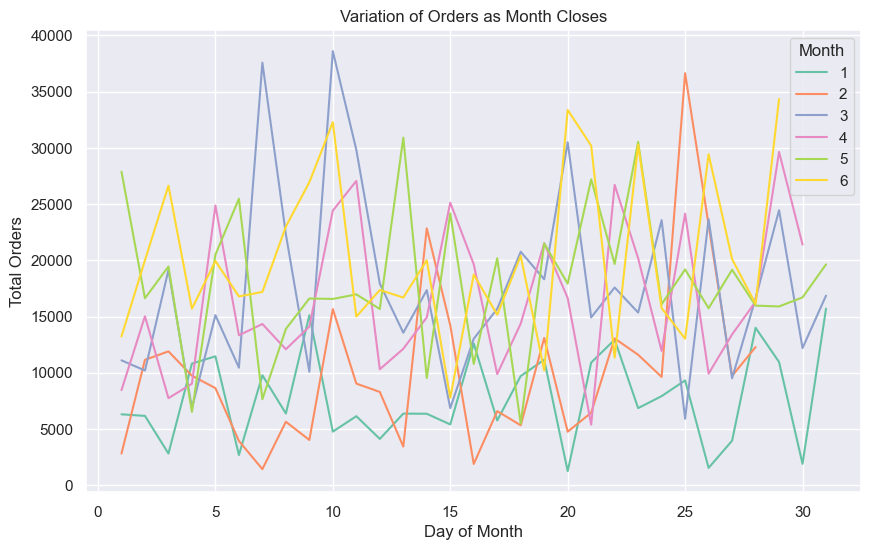

In [15]:
# Calculate the total orders per day
daily_orders = grouped_df.groupby(['month', 'day'])['order'].sum().reset_index()

# # Calculate the cumulative sum of orders
# daily_orders['cumulative_orders'] = daily_orders.groupby('month')['order'].cumsum()

# Plot the variation of orders as the month closes to the end
plt.figure(figsize=(10, 6))
sns.lineplot(x='day', y='order', hue='month', data=daily_orders, palette='Set2')
plt.title('Variation of Orders as Month Closes')
plt.xlabel('Day of Month')
plt.ylabel('Total Orders')
plt.legend(title='Month')
plt.show()

## Correlation Matrix Heatmap

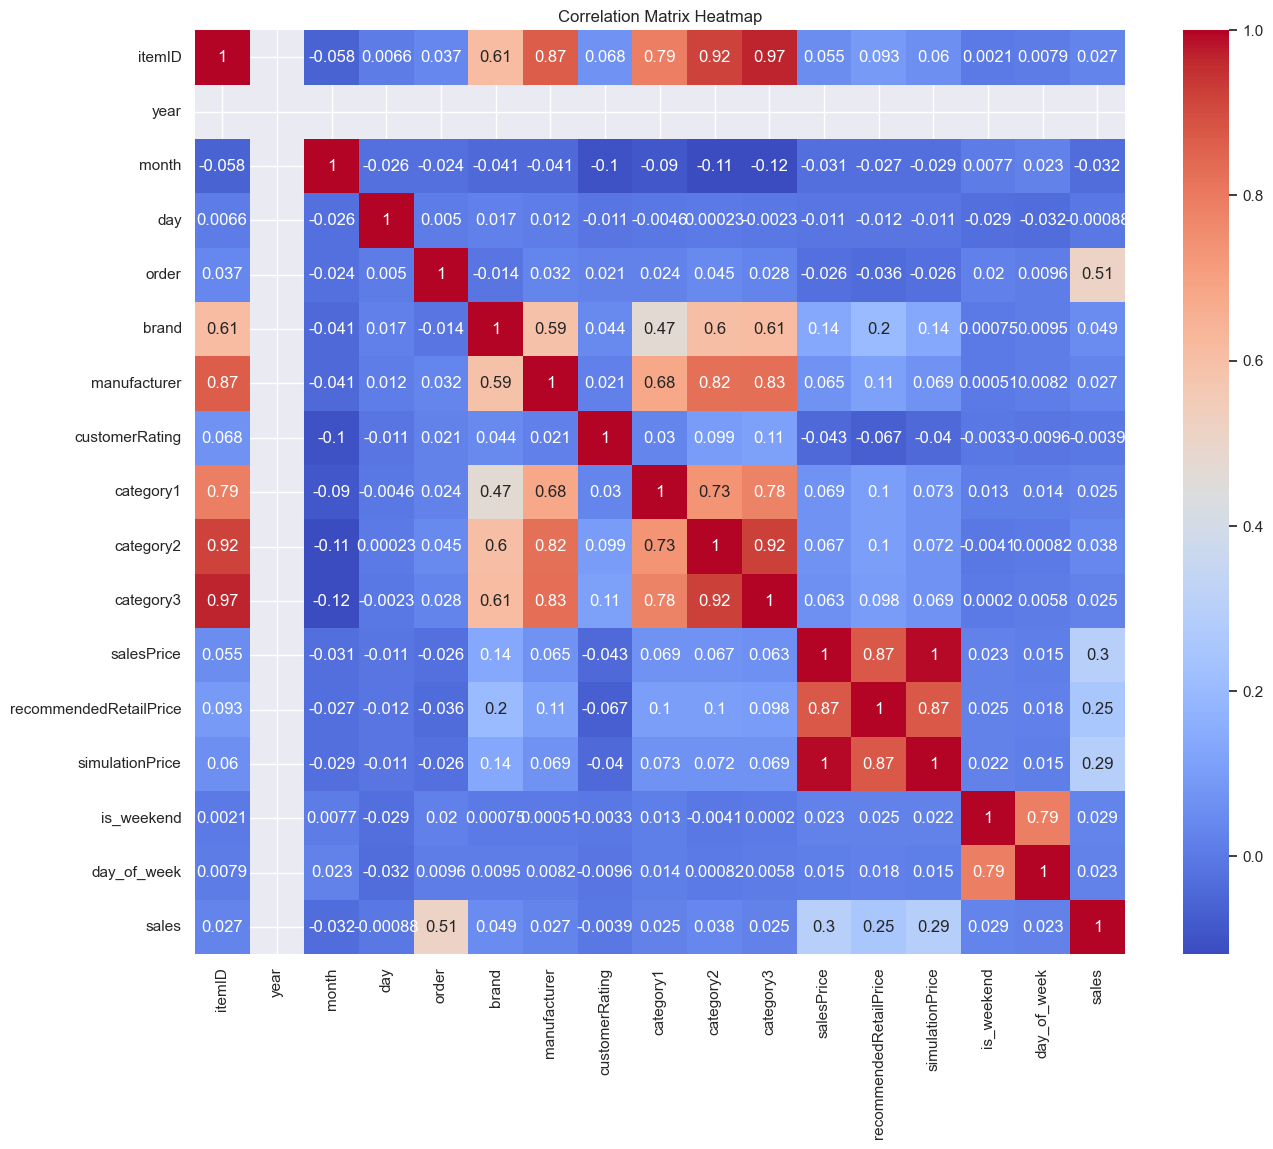

In [16]:
# Plot the correlation matrix heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(grouped_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Model Training and Evaluation

## Data Preparation

In [17]:
# Exclude 'year' column from the features
features = grouped_df.drop(['year', 'order'], axis=1)

# Set 'orders' column as the target variable
target = grouped_df['order']

# Display the shape of X and y
print('Shape of features (X):', features.shape)
print('Shape of target (y):', target.shape)

Shape of features (X): (100148, 15)
Shape of target (y): (100148,)


In [18]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Display the shapes of the training and test sets
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (90133, 15)
Shape of y_train: (90133,)
Shape of X_test: (10015, 15)
Shape of y_test: (10015,)


## Feature Scaling

In [19]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test features using the fitted scaler
X_test_scaled = scaler.transform(X_test)

## Training and Evaluation

In [20]:
# Define the models
models = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_jobs=-1)
}

# Iterate over the models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on training and validation data
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate MAE for training and validation
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Print the MAE for training and validation
    print(f'{model_name}:')
    print(f'Training MAE: {train_mae:.2f}')
    print(f'Validation MAE: {test_mae:.2f}')
    print('---')

Linear Regression:
Training MAE: 32.25
Validation MAE: 31.93
---
Lasso:
Training MAE: 32.14
Validation MAE: 31.87
---
Ridge:
Training MAE: 32.25
Validation MAE: 31.93
---
Decision Tree:
Training MAE: 0.00
Validation MAE: 1.93
---
Random Forest:
Training MAE: 0.38
Validation MAE: 0.98
---
